# Preprocessing + NN Playing for Beer Reviews

In [2]:
pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=1bf91f89ef257021edb2394f2530d7fb0609b13b1ab6a900072898e0591e3be4
  Stored in directory: /home/czeh/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 43.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 26.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 16.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 12.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 10.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arff

## Load Dataset and create Dataframe

In [5]:
data = arff.load(open('../data/beer_reviews.arff', 'r'))
attr = np.array(data['attributes'])
numericals = [i[0] for i in attr if i[1] == 'INTEGER' or i[1] == 'REAL']
df = pd.DataFrame(data['data'], columns=attr[:, 0])
df.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')

Use only 10% of the data

In [6]:
# from sklearn.model_selection import train_test_split
# _, df = train_test_split(df, test_size=0.1, random_state=42)

In [7]:
len(df)

1586614

In [8]:
df.columns

df['review_time'] = df['review_time'].apply(lambda sec: pd.Timestamp(sec, unit='s'))
display(df.head())

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


## Fix Missing Values

The rows with missing brewery name for id 1193 are found through a quick google search and added. For the ones with brewery id 27 where the beers already exist with the correct brewery, so I add it based on the dataset. For the others I google with the provided data.

The missing review profilenames are set to anonynoums, but otherwise kept, because the review is still done correctly.

In [9]:
display(df[df.isna().any(axis=1)])
display(df[df['brewery_name'].isna()])

display(df[df['brewery_id'] == 1193])
df.loc[df['brewery_id'] == 1193, 'brewery_name'] = 'Crailsheimer Engel-Bräu'
df.loc[df['brewery_id'] == 1193, 'beer_name'] = df.loc[df['brewery_id'] == 1193, 'beer_name'].apply(lambda name: name.split(' WRONG')[0])
display(df[df['brewery_id'] == 1193])

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
273,1075,Caldera Brewing Company,2004-12-21 22:29:55,3.0,3.0,3.0,RedDiamond,American Stout,4.0,3.0,Cauldron Espresso Stout,NaN,21241
430,850,Moon River Brewing Company,2005-03-13 17:48:30,3.5,4.0,4.5,cMonkey,Scotch Ale / Wee Heavy,3.5,3.5,The Highland Stagger,NaN,20689
603,850,Moon River Brewing Company,2004-11-09 22:20:19,4.0,3.5,4.0,aracauna,Scotch Ale / Wee Heavy,3.5,3.5,The Highland Stagger,NaN,20689
733,1075,Caldera Brewing Company,2009-12-13 03:12:01,4.0,4.0,4.0,plaid75,American IPA,4.0,4.0,Alpha Beta,NaN,54723
798,1075,Caldera Brewing Company,2008-05-31 02:34:28,4.5,4.5,4.0,grumpy,American Double / Imperial Stout,4.0,4.5,Imperial Stout,NaN,42964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586568,14359,The Defiant Brewing Company,2007-08-14 00:49:27,4.0,3.5,4.0,maddogruss,Bock,4.0,4.0,Bock,NaN,36424
1586587,14359,The Defiant Brewing Company,2007-04-29 10:22:48,3.5,4.5,4.0,BBM,Maibock / Helles Bock,4.5,4.0,Maibock,NaN,36555
1586596,14359,The Defiant Brewing Company,2010-10-24 20:11:07,4.0,3.0,5.0,hoppymcgee,Belgian Strong Pale Ale,4.0,3.5,Resolution #2,NaN,48360
1586597,14359,The Defiant Brewing Company,2009-05-09 21:57:03,4.5,4.5,4.0,WesWes,Belgian Strong Pale Ale,4.0,4.0,Resolution #2,NaN,48360


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
651565,1193,None,2011-03-25 03:01:06,2.0,2.5,2.5,Knapp85,Vienna Lager,1.5,1.5,Engel Tyrolian Bräu WRONG BREWERY SEE SCHWABIS...,5.0,67503
659293,1193,None,2010-11-18 19:14:58,4.0,4.5,3.5,dqrull,Bock,4.0,3.5,Engel Bock Dunkel WRONG BREWERY SEE CRAILSHEIMER,7.2,63658
659299,1193,None,2010-11-06 20:56:41,3.5,3.0,3.0,dqrull,Dortmunder / Export Lager,4.0,4.0,Engel Gold WRONG BREWERY SEE CRAILSHEIMER,5.4,63215
659300,1193,None,2010-11-15 19:57:13,3.5,4.0,3.5,dqrull,Munich Helles Lager,3.5,3.0,Engel Landbier WRONG BREWERY SEE CRAILSHEIMER,4.8,63557
659301,1193,None,2010-11-07 19:37:12,3.5,4.0,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,3.5,Engel Keller Hell WRONG BREWERY SEE CRAILSHEIMER,5.4,63256
659302,1193,None,2010-11-12 19:27:45,3.5,4.0,3.0,dqrull,Vienna Lager,3.0,3.5,Engel Aloisius - WRONG BREWERY SEE CRAILSHEIMER,5.9,63459
659303,1193,None,2011-02-19 01:28:46,3.0,3.0,3.0,Ochsenblut,Keller Bier / Zwickel Bier,2.0,3.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659304,1193,None,2010-12-15 14:27:51,4.5,4.0,4.0,Dentist666,Keller Bier / Zwickel Bier,4.0,4.5,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659305,1193,None,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
1391043,27,None,2002-05-01 09:20:56,3.5,3.5,3.5,Jason,American Adjunct Lager,4.0,3.5,Hard Hat American Beer,3.8,60


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
651565,1193,None,2011-03-25 03:01:06,2.0,2.5,2.5,Knapp85,Vienna Lager,1.5,1.5,Engel Tyrolian Bräu WRONG BREWERY SEE SCHWABIS...,5.0,67503
659293,1193,None,2010-11-18 19:14:58,4.0,4.5,3.5,dqrull,Bock,4.0,3.5,Engel Bock Dunkel WRONG BREWERY SEE CRAILSHEIMER,7.2,63658
659299,1193,None,2010-11-06 20:56:41,3.5,3.0,3.0,dqrull,Dortmunder / Export Lager,4.0,4.0,Engel Gold WRONG BREWERY SEE CRAILSHEIMER,5.4,63215
659300,1193,None,2010-11-15 19:57:13,3.5,4.0,3.5,dqrull,Munich Helles Lager,3.5,3.0,Engel Landbier WRONG BREWERY SEE CRAILSHEIMER,4.8,63557
659301,1193,None,2010-11-07 19:37:12,3.5,4.0,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,3.5,Engel Keller Hell WRONG BREWERY SEE CRAILSHEIMER,5.4,63256
659302,1193,None,2010-11-12 19:27:45,3.5,4.0,3.0,dqrull,Vienna Lager,3.0,3.5,Engel Aloisius - WRONG BREWERY SEE CRAILSHEIMER,5.9,63459
659303,1193,None,2011-02-19 01:28:46,3.0,3.0,3.0,Ochsenblut,Keller Bier / Zwickel Bier,2.0,3.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659304,1193,None,2010-12-15 14:27:51,4.5,4.0,4.0,Dentist666,Keller Bier / Zwickel Bier,4.0,4.5,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659305,1193,None,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
651565,1193,Crailsheimer Engel-Bräu,2011-03-25 03:01:06,2.0,2.5,2.5,Knapp85,Vienna Lager,1.5,1.5,Engel Tyrolian Bräu,5.0,67503
659293,1193,Crailsheimer Engel-Bräu,2010-11-18 19:14:58,4.0,4.5,3.5,dqrull,Bock,4.0,3.5,Engel Bock Dunkel,7.2,63658
659299,1193,Crailsheimer Engel-Bräu,2010-11-06 20:56:41,3.5,3.0,3.0,dqrull,Dortmunder / Export Lager,4.0,4.0,Engel Gold,5.4,63215
659300,1193,Crailsheimer Engel-Bräu,2010-11-15 19:57:13,3.5,4.0,3.5,dqrull,Munich Helles Lager,3.5,3.0,Engel Landbier,4.8,63557
659301,1193,Crailsheimer Engel-Bräu,2010-11-07 19:37:12,3.5,4.0,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,3.5,Engel Keller Hell,5.4,63256
659302,1193,Crailsheimer Engel-Bräu,2010-11-12 19:27:45,3.5,4.0,3.0,dqrull,Vienna Lager,3.0,3.5,Engel Aloisius -,5.9,63459
659303,1193,Crailsheimer Engel-Bräu,2011-02-19 01:28:46,3.0,3.0,3.0,Ochsenblut,Keller Bier / Zwickel Bier,2.0,3.0,Engel Keller Dunkel,5.3,63324
659304,1193,Crailsheimer Engel-Bräu,2010-12-15 14:27:51,4.5,4.0,4.0,Dentist666,Keller Bier / Zwickel Bier,4.0,4.5,Engel Keller Dunkel,5.3,63324
659305,1193,Crailsheimer Engel-Bräu,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel,5.3,63324


In [10]:
display(df[df['brewery_id'] == 27])

if (1391053 in df.index):
    df.loc[1391053, 'brewery_id'] = 24831
    df.loc[1391053, 'brewery_name'] = 'American Brewing Company'

if (1391051 in df.index):
    df.loc[1391051, 'brewery_id'] = 24831
    df.loc[1391051, 'brewery_name'] = 'American Brewing Company'

if (1391052 in df.index):  
    df.loc[1391052, 'brewery_id'] = 24831
    df.loc[1391052, 'brewery_name'] = 'American Brewing Company'

if (1391049 in df.index):  
    df.loc[1391049, 'brewery_id'] = 782
    df.loc[1391049, 'brewery_name'] = 'City Brewing Company, LLC'
    df.loc[1391049, 'beer_name'] = 'Side Pocket High Gravity Ale'

if (1391050 in df.index):  
    df.loc[1391050, 'brewery_id'] = 782
    df.loc[1391050, 'brewery_name'] = 'City Brewing Company, LLC'
    df.loc[1391050, 'beer_name'] = 'Side Pocket High Gravity Ale'

if (1391043 in df.index):  
    df.drop(1391043, inplace=True)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
1391043,27,None,2002-05-01 09:20:56,3.5,3.5,3.5,Jason,American Adjunct Lager,4.0,3.5,Hard Hat American Beer,3.8,60
1391049,27,None,2006-03-24 06:49:16,2.5,2.0,2.0,BeerBob,American Malt Liquor,2.0,2.0,Side Pocket,8.5,3394
1391050,27,None,2005-06-05 09:20:32,1.5,1.5,2.0,feloniousmonk,American Malt Liquor,1.5,1.5,Side Pocket,8.5,3394
1391051,27,None,2011-12-08 03:24:34,4.5,4.5,3.5,ccrida,American IPA,4.5,4.5,Breakaway IPA,7.2,75135
1391052,27,None,2011-11-11 05:36:14,3.5,4.0,3.5,Docer,American IPA,4.0,4.0,Breakaway IPA,7.2,75135
1391053,27,None,2011-11-11 07:10:08,5.0,4.5,4.0,Docer,American Stout,4.5,4.5,Caboose Oatmeal Stout,7.0,75137


In [11]:
df.loc[df['review_profilename'].isna(), 'review_profilename'] = 'Anonymous'

In [12]:
len(df['beer_style'].unique())

104

In [13]:
display(len(df.loc[df['beer_abv'].isna(), 'beer_name'].unique()))

def create_mean(df):
    means = {}
    for style in df['beer_style'].unique():
        mean_abv = df.loc[df['beer_style'] == style, 'beer_abv'].mean()
        means[style] = round(mean_abv, 1)

    return means

def fill_mean(means, row):
    return 

means = create_mean(df)
print(means)
df.loc[df['beer_abv'].isna(), 'beer_abv'] = df.loc[df['beer_abv'].isna()].apply(lambda row: means[row['beer_style']], axis=1)

14110

{'Hefeweizen': 5.3, 'English Strong Ale': 7.3, 'Foreign / Export Stout': 7.7, 'German Pilsener': 5.0, 'American Double / Imperial IPA': 9.4, 'Herbed / Spiced Beer': 6.6, 'Light Lager': 4.0, 'Oatmeal Stout': 5.8, 'American Pale Lager': 5.0, 'Rauchbier': 5.7, 'American Pale Ale (APA)': 5.5, 'American Porter': 6.2, 'Belgian Strong Dark Ale': 9.4, 'American IPA': 6.6, 'American Stout': 6.3, 'Russian Imperial Stout': 10.0, 'American Amber / Red Ale': 6.0, 'American Strong Ale': 9.8, 'Märzen / Oktoberfest': 5.9, 'American Adjunct Lager': 4.9, 'American Blonde Ale': 5.0, 'Euro Pale Lager': 5.1, 'English Brown Ale': 5.2, 'Scotch Ale / Wee Heavy': 8.2, 'Fruit / Vegetable Beer': 5.8, 'American Double / Imperial Stout': 10.6, 'Belgian Pale Ale': 6.1, 'English Bitter': 4.3, 'English Porter': 5.7, 'Irish Dry Stout': 4.9, 'American Barleywine': 10.7, 'Belgian Strong Pale Ale': 8.7, 'Doppelbock': 8.3, 'Maibock / Helles Bock': 6.8, 'Pumpkin Ale': 6.6, 'Dortmunder / Export Lager': 5.5, 'Euro Strong Lag

In [14]:
print(df[df.isna().any(axis=1)].count())

brewery_id            0
brewery_name          0
review_time           0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64


## Bag of Word for Brewery and Beer Name

In [15]:
from string import punctuation
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import sklearn
sklearn.set_config(transform_output="pandas")

In [16]:
PUNCT_TO_REMOVE = punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [17]:
df["brewery_name"] = df["brewery_name"].str.lower()
df["brewery_name"] = df["brewery_name"].apply(lambda text: remove_punctuation(text))

df["beer_name"] = df["beer_name"].str.lower()
df["beer_name"] = df["beer_name"].apply(lambda text: remove_punctuation(text))

df["text"] = df["brewery_name"] + " " + df["beer_name"]
df['text']

0                           vecchio birraio sausa weizen
1                               vecchio birraio red moon
2                 vecchio birraio black horse black beer
3                             vecchio birraio sausa pils
4                  caldera brewing company cauldron dipa
                               ...                      
1586609    the defiant brewing company the horsemans ale
1586610    the defiant brewing company the horsemans ale
1586611    the defiant brewing company the horsemans ale
1586612    the defiant brewing company the horsemans ale
1586613    the defiant brewing company the horsemans ale
Name: text, Length: 1586613, dtype: object

In [18]:
cnt = Counter()
for text in df["text"].values:
    for word in text.split():
        cnt[word] += 1
        
FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])

counts = list(cnt.values())
print(len(counts))
print(FREQWORDS)

30801
{'imperial', 'samuel', 'stout', 'the', 'lager', 'co', 'de', 'nevada', 'brouwerij', 'beer', 'ale', 'adams', 'porter', 'company', 'pale', 'stone', 'brewery', 'sierra', 'brewing', 'ipa'}


In [19]:
n_rare = sum([i <= 100 for i in counts])
print(n_rare)
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare-1:-1]])

def remove_rarewords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text"] = df["text"].apply(lambda text: remove_rarewords(text))

25905


In [20]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
words.set_index(df.index, inplace=True)
words

,003,01,015,016,02,03,030303,04,040404,05,...,õlletehas,ölvisholt,österreich,øjolly,ølfabrikken,über,übersun,švyturys,žatec,žatecký
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_bag = df.merge(words, how='left', left_index=True, right_index=True)

In [22]:
words.index.equals(df.index)

True

## Splitting Training and Test Set

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [24]:
le = LabelEncoder()
le.fit(df['beer_style'])
df['class'] = le.transform(df['beer_style'])

In [25]:
# le = LabelEncoder()
# le.fit(df['review_profilename'])
# df['review_profilecode'] = le.transform(df['review_profilename'])

In [26]:
X = df.copy()
X.drop('brewery_name', axis=1, inplace=True)
X.drop('brewery_id', axis=1, inplace=True)
X.drop('beer_name', axis=1, inplace=True)
X.drop('beer_beerid', axis=1, inplace=True)
X.drop('beer_style', axis=1, inplace=True)
X.drop('review_profilename', axis=1, inplace=True)
X.drop('review_time', axis=1, inplace=True)
X.drop('text', axis=1, inplace=True)

y = df['class']
X.drop('class', axis=1, inplace=True)
# X = normalize(X, norm='l2')
X

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
0,1.5,2.0,2.5,1.5,1.5,5.0
1,3.0,2.5,3.0,3.0,3.0,6.2
2,3.0,2.5,3.0,3.0,3.0,6.5
3,3.0,3.0,3.5,2.5,3.0,5.0
4,4.0,4.5,4.0,4.0,4.5,7.7
...,...,...,...,...,...,...
1586609,5.0,4.0,3.5,4.0,4.0,5.2
1586610,4.0,5.0,2.5,2.0,4.0,5.2
1586611,4.5,3.5,3.0,3.5,4.0,5.2
1586612,4.0,4.5,4.5,4.5,4.5,5.2


In [27]:
X.index.equals(words.index)

True

In [28]:
X_train, X_valid, words_train, words_valid, y_train, y_valid = train_test_split(X, words, y, test_size=0.33, random_state=42)
# words_train, words_test, y_train, y_test = train_test_split(words, y, test_size=0.33, random_state=42)


In [29]:
print(len(X_train))
print(len(words_train))
print(len(y_train))
print(X_train.index.equals(y_train.index))
print(X_train.index.equals(words_train.index))
print(y.max())

1063030
1063030
1063030
True
True
103


## Scaling, Feature Selection, Outlier

## Check for Outliers

array([[<Axes: title={'center': 'review_overall'}>,
        <Axes: title={'center': 'review_aroma'}>],
       [<Axes: title={'center': 'review_appearance'}>,
        <Axes: title={'center': 'review_palate'}>],
       [<Axes: title={'center': 'review_taste'}>,
        <Axes: title={'center': 'beer_abv'}>]], dtype=object)

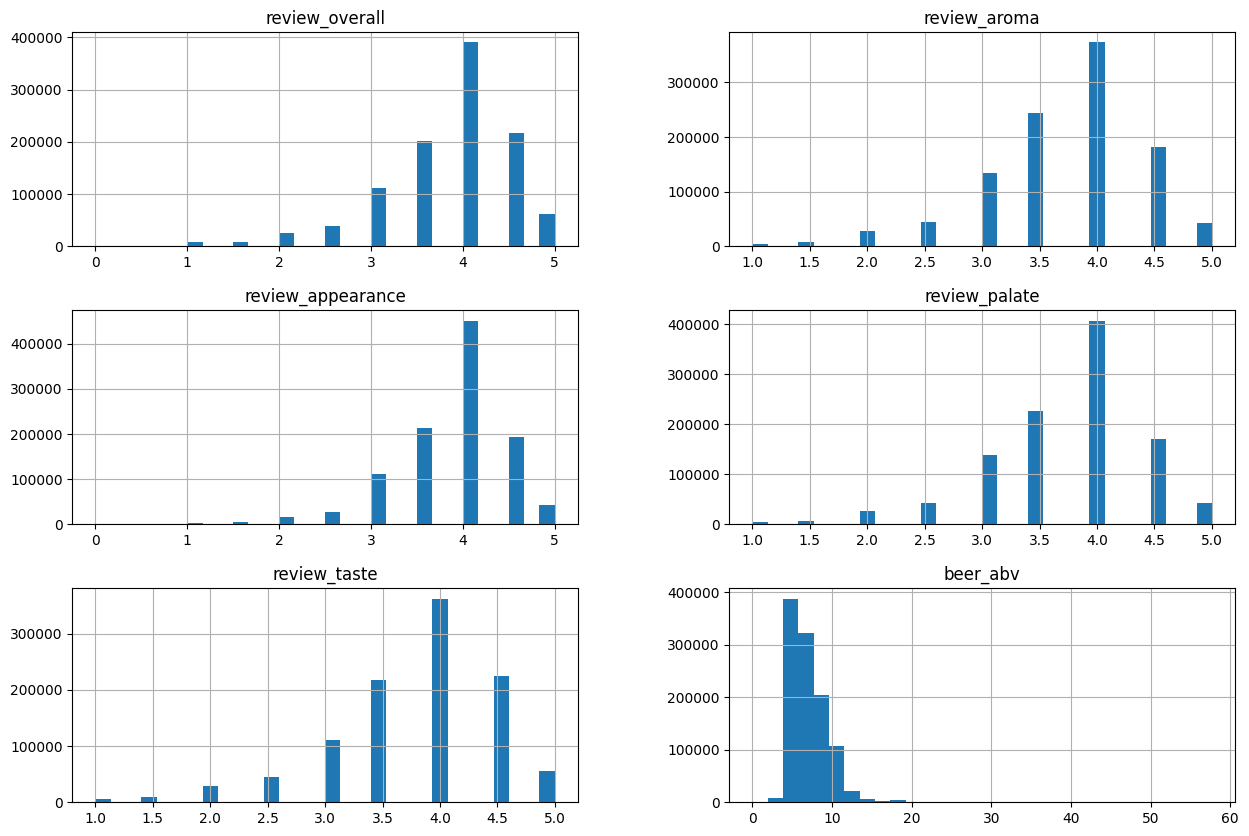

In [30]:
X_train.hist(bins=30, figsize=(15, 10))

In [31]:
len(X_train[X_train['beer_abv'] > 31])
len(X_train[X_train['beer_abv'] > 50])
X_train[X_train['beer_abv'] > 50]

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
12919,4.0,4.0,4.0,4.0,3.5,57.7


Looks like there exist really that strong beers.

## Feature Selection

In [32]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = RandomForestClassifier(n_estimators=20, max_features=100).fit(words_train, y_train)
model = SelectFromModel(clf, prefit=True)
words_new = model.transform(words_train)
words_new

/home/czeh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,080808,090909,10,100,11,12,120,13,13th,15,...,xs,xxx,yakima,yards,yeti,youngs,yuengling,yulesmith,éphémère,ølfabrikken
346231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
605885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1556899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1357582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1414415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131932,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
671155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# words_new = words_train[words_train.columns[:100]]

In [35]:
words_train.index.equals(X_train.index)

True

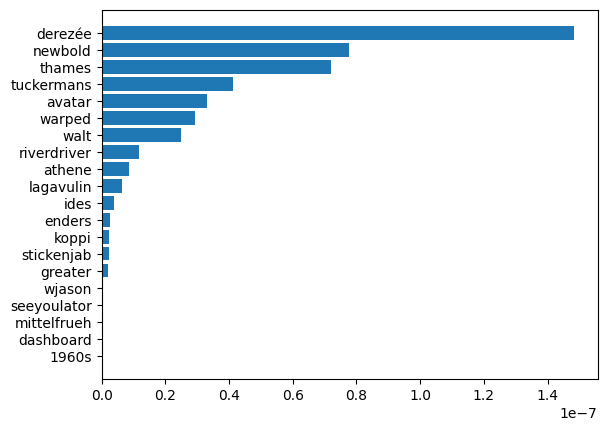

In [36]:
f_i = list(zip(clf.feature_names_in_,clf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i = f_i[:20]
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [37]:
X_train_bag = X_train.merge(words_new, how='inner', left_index=True, right_index=True)

In [38]:
X_train_bag

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,080808,090909,10,100,...,xs,xxx,yakima,yards,yeti,youngs,yuengling,yulesmith,éphémère,ølfabrikken
346231,4.0,4.0,4.0,4.0,4.0,4.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
605885,2.5,2.0,3.0,2.0,2.0,4.6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56385,4.0,3.5,3.5,4.0,4.0,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1556899,2.0,3.0,4.0,4.0,2.5,9.1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1357582,4.0,4.0,4.5,4.0,4.0,6.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,2.5,2.0,2.0,3.0,2.5,8.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1414415,3.5,3.0,4.0,3.5,3.5,6.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131932,4.0,4.0,4.0,4.0,3.5,10.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
671155,4.0,3.5,4.0,4.0,4.0,7.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X_valid_bag = X_valid.merge(words_valid[words_new.columns], how='inner', left_index=True, right_index=True)
X_valid_bag

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,080808,090909,10,100,...,xs,xxx,yakima,yards,yeti,youngs,yuengling,yulesmith,éphémère,ølfabrikken
678952,2.0,2.0,4.0,3.0,2.5,5.1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
451825,4.5,4.5,4.5,4.5,4.0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1270455,4.0,4.5,4.0,3.5,4.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
606827,3.0,2.5,2.5,4.0,3.0,5.1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
351395,3.0,3.0,1.5,3.5,3.5,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836100,3.5,4.0,4.0,4.0,3.5,6.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
587929,3.5,5.0,3.5,4.0,4.0,9.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1018000,2.5,3.0,4.0,3.5,3.5,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
431179,5.0,5.0,4.5,4.5,5.0,7.1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Find Solution for NN

In [40]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [41]:
X_ttrain, X_test, y_ttrain, y_test = train_test_split(X_train_bag.values, y_train.values, test_size=0.3, random_state=42)

In [42]:
print(X_ttrain)
print(y_ttrain)
print(y_ttrain.max())

[[3.5 3.5 3.  ... 0.  0.  0. ]
 [2.  2.5 2.5 ... 0.  0.  0. ]
 [4.  4.  3.5 ... 0.  0.  0. ]
 ...
 [4.  4.5 4.  ... 0.  0.  0. ]
 [5.  4.5 5.  ... 0.  0.  0. ]
 [4.  4.5 4.  ... 0.  0.  0. ]]
[ 80  54  17 ... 100  26  12]
103


## Build torch dataset

In [43]:
assert not np.any(np.isnan(X_ttrain))
assert not np.any(np.isnan(y_ttrain))
assert not np.any(np.isnan(X_test))
assert not np.any(np.isnan(y_test))

In [46]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# convert a df to tensor to be used in pytorch
def X_to_tensor(df):
    return torch.from_numpy(df).float().to(device)

def y_to_tensor(df):
    return torch.from_numpy(df).long().to(device)

X_train_tensor = X_to_tensor(X_ttrain)
y_train_tensor = y_to_tensor(y_ttrain)

X_test_tensor = X_to_tensor(X_test)
y_test_tensor = y_to_tensor(y_test)

X_valid_tensor = X_to_tensor(X_valid_bag.values)
y_valid_tensor = y_to_tensor(y_valid.values)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
valid_ds = TensorDataset(X_valid_tensor, y_valid_tensor)

Using cpu device


In [47]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size)

for XX, yy in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {XX.shape}")
    print(f"Shape of y: {yy.shape} {yy.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 920])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(X_ttrain[0]), 250),
            nn.ReLU(),
            nn.Linear(250, 164),
            nn.ReLU(),
            nn.Linear(164, 164),
            nn.ReLU(),
            nn.Linear(164, 104)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


## Train the Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (XX, yy) in enumerate(dataloader):
        XX, yy = XX.to(device), yy.to(device)

        # Compute prediction error
        pred = model(XX)
        loss = loss_fn(pred, yy)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(XX)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for XX, yy in dataloader:
            XX, yy = XX.to(device), yy.to(device)
            pred = model(XX)
            test_loss += loss_fn(pred, yy).item()
            # correct += (pred.argmax(1) == yy).type(torch.float).sum().item()
            correct += f1_score(yy, pred, average='weighted')
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
%%capture cap

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
with open('../results/beer_train_initial_nn_all.txt', 'w+') as f:
    f.write(cap.stdout)

Best: 89.5% -> 30 epochs

## Test model

In [ ]:
%%capture cap
test(valid_dataloader, model, loss_fn)

In [ ]:
with open('../results/beer_test_initial_nn_all.txt', 'w+') as f:
    f.write(cap.stdout)

Result for validation set: 90.2%

# Parameter Search

Parameter to test: Learning Rate, Batch Size, Layer Nodes, Activation Function, Dropout \
Activation Function: relu, sigmoid, linear

## Shrink Dataset

Use only 2% of the data for parameter testing.

In [62]:
_, X_train_bag_small, _, y_train_small = train_test_split(X_train_bag, y_train, test_size=0.01, random_state=42)

In [63]:
print(len(X_train_bag_small))
print(len(y_train_small))

10631
10631


In [64]:
X_ttrain_small, X_test_small, y_ttrain_small, y_test_small = train_test_split(X_train_bag_small.values, y_train_small.values, test_size=0.3, random_state=42)

In [65]:
X_train_small_tensor = X_to_tensor(X_ttrain_small)
y_train_small_tensor = y_to_tensor(y_ttrain_small)

X_test_small_tensor = X_to_tensor(X_test_small)
y_test_small_tensor = y_to_tensor(y_test_small)

train_small_ds = TensorDataset(X_train_small_tensor, y_train_small_tensor)
test_small_ds = TensorDataset(X_test_small_tensor, y_test_small_tensor)

## Run Searches

In [66]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
%autoreload 2

In [105]:
def acc_func(loc_pred, loc_y):
    # return (loc_pred.argmax(1) == loc_y).type(torch.float).sum().item()
    return f1_score(loc_y, loc_pred.argmax(1), average='weighted')

In [106]:
from NNModel import NNModel

In [107]:
layer = [len(X_ttrain[0]), 250, 164, 164, 104]
nnmodel = NNModel(layer, device, acc_func=acc_func, loss_func=nn.CrossEntropyLoss)

## Grid Search

In [ ]:
%%capture cap
test_layer = [[len(X_ttrain[0]), 250, 164, 164, 104], [len(X_ttrain[0]), 25, 16, 16, 104], [len(X_ttrain[0]), 250, 164, 104]]
dict_param_1 = {"learning_rate": [0.001, 0.01, 0.05], "batch_size": [32, 64, 128]}
best, acc = nnmodel.grid_search(dict_param_1, train_small_ds, test_small_ds, epochs=30)
best

In [100]:
with open('../results/beer_grid_search_training_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [93]:
%%capture cap
nnmodel.defaults["learning_rate"] = best[0]
nnmodel.defaults["batch_size"] = best[1]
dict_param_2 = {"activation": [nn.ReLU, nn.Sigmoid, nn.Identity], "dropout": [0, 0.2, 0.3, 0.5], "layer": test_layer}
best, acc = nnmodel.grid_search(dict_param_2, train_small_ds, test_small_ds, epochs=30)
best

ValueError: batch_size should be a positive integer value, but got batch_size=0

In [94]:
with open('../results/beer_grid_search_model_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [86]:
nnmodel.defaults["activation"] = best[0]
nnmodel.defaults["dropout"] = best[1]
nnmodel.defaults["layer"] = best[2]

In [ ]:
%%capture cap
nnmodel.create_model(nnmodel.defaults["layer"], nnmodel.defaults["activation"], nnmodel.defaults["dropout"])
nnmodel.run(nnmodel.defaults, train_ds, test_ds, 30)

In [ ]:
with open('../results/beer_grid_search_res.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
%%capture cap
test(valid_dataloader, nnmodel.model, nnmodel.loss_fn)

In [ ]:
with open('../results/beer_grid_search_res_valid.txt', 'w+') as f:
    f.write(cap.stdout)

## Local Search

In [ ]:
nnmodel = NNModel(layer, device, acc_func=acc_func, loss_func=nn.CrossEntropyLoss)

In [ ]:
%%capture cap
init_param = {"learning_rate": 0.01, "batch_size": 64}
best, acc = nnmodel.local_search(init_param, train_small_ds, test_small_ds, steps=50, epochs=30)

In [ ]:
with open('../results/beer_local_search_training_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
%%capture cap
nnmodel.defaults["learning_rate"] = best[0]
nnmodel.defaults["batch_size"] = best[1]
init_param = {"layer": layer, "dropout": 0.2, "activation": nn.ReLU}
best, acc = nnmodel.local_search(init_param, train_small_ds, test_small_ds, steps=50, epochs=30)

In [ ]:
with open('../results/beer_local_search_model_1p.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
nnmodel.defaults["activation"] = best[0]
nnmodel.defaults["dropout"] = best[1]
nnmodel.defaults["layer"] = best[2]

In [ ]:
%%capture cap
nnmodel.create_model(nnmodel.defaults["layer"], nnmodel.defaults["activation"], nnmodel.defaults["dropout"])
nnmodel.run(nnmodel.defaults, train_ds, test_ds, 30)

In [ ]:
with open('../results/beer_local_search_res.txt', 'w+') as f:
    f.write(cap.stdout)

In [ ]:
%%capture cap
test(valid_dataloader, nnmodel.model, nnmodel.loss_fn)

In [ ]:
with open('../results/housing_local_search_res_valid.txt', 'w+') as f:
    f.write(cap.stdout)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=3, random_state=42)  

rf.fit(X_train, y_train)
y_prediction = rf.predict(X_valid)

In [ ]:
%%capture cap
from sklearn.metrics import f1_score, accuracy_score

accuracy = accuracy_score(y_valid, y_prediction)
print(f'Mean Squared Error: {accuracy}')

f1 = f1_score(y_valid, y_prediction)
print(f'R-squared: {f1}')


In [ ]:
with open('../results/beer_forest_all.txt', 'w+') as f:
    f.write(cap.stdout)